In [1]:
import h5py
import numpy as np
import scipy.ndimage
import scipy.optimize
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras

import time

import matplotlib.pyplot as plt

# Load in data

In [3]:
filename = "../../../../../cscratch1/sd/jupiter/sim2_z3_FGPA_cgs.h5"
tf_filename = "../lya_fields/results/tf_fields1x1x1024.h5"

h5 = h5py.File(filename,'r')
tf_h5 = h5py.File(tf_filename,'r')

# full fields
DM_dens = h5['native_fields']['matter_density'][()] # rho
baryon_dens = h5['native_fields']['baryon_density'][()] # rho_b
temperature = h5['native_fields']['temperature'][()] # T

treal = tf_h5['tau_real'][()] # real-space optical depth (lya-tf)
treal_g = h5['derived_fields']['tau_real'][()] # real-space optical depth (Gimlet)

h5.close()
tf_h5.close()

# Fit the DM-to-baryon formulas

Let $\rho$ be the ratio of dark matter density to the mean DM density, and let $\rho_b$ be the same for baryons. Let $\sigma_T$ and $\sigma_\rho$ be the smoothing scales for temperature and baryon density, respectively.

Baryon temperature:
$$T = T_0 [\text{gaussian_smoothing}(\rho, \sigma_T)]^{\gamma_T-1} $$
Baryon density:
$$\rho_b = \rho_{b,0} [\text{gaussian_smoothing}(\rho, \sigma_\rho)]^{\gamma_\rho-1} $$

In [3]:
# train on one part of the snapshot
train_inds = (512,
              slice(0, 1024),
              slice(0, 1024))
rho_train = DM_dens[train_inds]
rhob_train = baryon_dens[train_inds]
temp_train = temperature[train_inds]

# test on one skewer
test_inds = (0, 0, slice(0, 1024))
rho_test = DM_dens[test_inds]
rhob_test = baryon_dens[test_inds]
temp_test = temperature[test_inds]

In [102]:
def bary_model(x0, sigma, gamma):
    '''
    The model for fitting x = x0 * [gaussian_smoothing(rho, sigma)]^(gamma-1),
    where x is the baryon property.
    
    '''
    
    return x0 * (scipy.ndimage.gaussian_filter(rho_train, sigma))**(gamma - 1)

def obj_fn(params):
    '''
    The objective function to be minimized for fitting. 
    
    PARAMETERS
    ----------
    x: the baryon property to fit, either 'rho' (baryon density) or 't' (temperature)
    
    '''
    
    x0, sigma, gamma, x = params
    
    x_pred = bary_model(x0, sigma, gamma)
    
    if x == 'rho':
        return np.mean(np.square(rhob_train - x_pred))
    elif x == 't':
        return np.mean(np.square(temp_train - x_pred))
    else:
        raise ValueError("Invalid argument: x must be either 'rho' or 't'")

## testing gaussian_filter

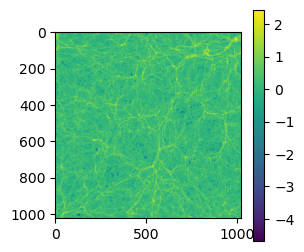

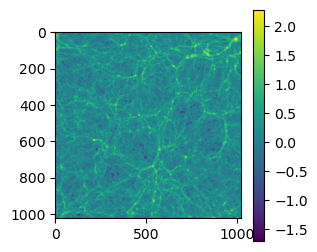

In [115]:
plt.figure(figsize=(3,3))
plt.imshow(np.log10(bary_model(3, 1.5, 1.6)))
plt.colorbar()
plt.show()

plt.figure(figsize=(3,3))
plt.imshow(np.log10(bary_model(3, 2.5, 1.6)))
plt.colorbar()
plt.show()

## Attempt 1 (scipy.optimize.minimize, doesn't work)

This doesn't optimize at all; it runs 0 iterations and ends with a Jacobian of `array([0., 0., 0.])`. I suspect it's because gaussian_filter doesn't have a built-in gradient.

In [12]:
guess = (np.mean(rhob_train), np.std(rhob_train), 1.6)
options = {'maxiter': 10, 'disp': True}
result = scipy.optimize.minimize(obj_fn, guess, args=('rho')), options = options)

In [23]:
result

      fun: 20.845213
 hess_inv: array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])
      jac: array([0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0.        , 4.49901867, 1.5       ])

## Attempt 2 (trial and error)

In [12]:
guess = (np.mean(rhob_train), np.std(rhob_train), 1.6, 'rho')
obj_fn(guess)

16.926563

In [63]:
# def obj_fn_vec(x0, sigma, gamma=1.6, x='rho'):
#     '''
#     A vectorized version of obj_fn.
    
#     PARAMETERS
#     ----------
#     x0, sigma, gamma: the parameters to be fitted
#     x: a string, either 'rho' (for baryon density) or 't' (for temperature)
    
#     '''
    
#     params = (x0, sigma, gamma)
#     return obj_fn(params, x)

# obj_fn_vec(0.8, 4.5, 2, 'rho')

4.438488

### adjusting x0 and sigma

https://stackoverflow.com/questions/61107875/how-to-pass-meshgrid-as-an-argument-to-a-function-which-only-allows-an-array-in

In [52]:
n = 11
x0 = np.linspace(2.5, 3.5, n)
sigma = np.linspace(1, 2, n)
losses = np.ndarray((n,n))

#X0, Sigma = np.meshgrid(x0, sigma)#, sparse=True)

#result = map(lambda params: obj_fn_vec(params[0], params[1]), \
             #zip(X0.flatten(), Sigma.flatten()))
    
# losses = np.fromiter(result, dtype=np.float)
# losses = np.reshape(losses, (n,n))

In [53]:
start = time.time()

for i in range(n):
    for j in range(n):
        params = (x0[i], sigma[j], 1.6, 'rho')
        losses[i,j] = obj_fn(params)
        
print('Duration:', np.round(time.time() - start, 3))

plt.imshow(losses)
plt.colorbar()
plt.show()

Duration: 13.456


In [62]:
from numpy import unravel_index

min_index = np.argmin(losses)
min_ind = unravel_index(min_index, losses.shape)

best_rho0 = x0[min_ind[0]]
best_sigma_rho = sigma[min_ind[1]]

print('Minimum loss:', losses[min_ind])
print('\nBest values:')
print('rho0 = ' + str(best_rho0))
print('sigma_rho = ' + str(best_sigma_rho))

Minimum loss: 8.796258926391602

Best values:
x0 = 3.2
sigma = 1.4


Do the same for temperature.

In [122]:
for i in range(1, 6):
    params = (10000, i, 1.6, 't')
    print(obj_fn(params))

28114178.0
15023663.0
11571787.0
11959381.0
13681554.0


In [98]:
print('mean(T):', np.mean(temp_train))

mean(T): 8722.626


Duration: 14.395


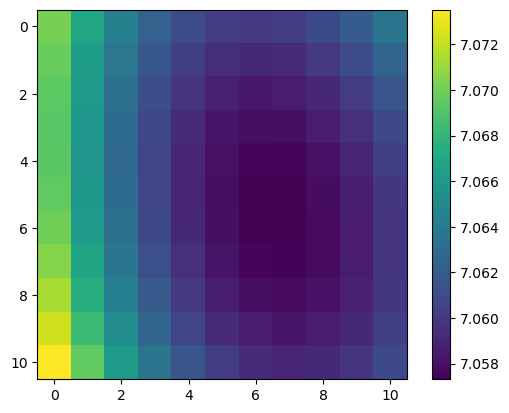

In [138]:
n = 11
log10_t0 = np.linspace(3.98, 4.001, n)
t0 = 10**log10_t0
sigma_t = np.linspace(2.8, 3.5, n)

losses = np.ndarray((n,n))

start = time.time()

for i in range(n):
    for j in range(n):
        #print('hi')
        params = (t0[i], sigma_t[j], 1.6, 't')
        losses[i,j] = obj_fn(params)
        
print('Duration:', np.round(time.time() - start, 3))

plt.imshow(np.log10(losses))
plt.colorbar()
plt.show()

In [141]:
min_ind

(6, 7)

In [140]:
min_index = np.argmin(losses)
min_ind = unravel_index(min_index, losses.shape)

best_t0 = t0[min_ind[0]]
best_sigma_t = sigma_t[min_ind[1]]

print('Minimum loss:', losses[min_ind])
print('\nBest values:')
print('T_0 = ' + str(best_t0))
print('sigma_T = ' + str(best_sigma_t))

Minimum loss: 11410698.0

Best values:
T_0 = 9831.0521528177
sigma_T = 3.29


### adjusting gamma

In [ ]:
gammas = np.linspace(1.7, 1.71, 10)
losses = np.empty_like(gammas)

for i in range(len(gammas)):
    losses[i] = obj_fn((3.2, 1.4, gammas[i], 'rho'))
    
plt.plot(losses)
plt.show()

## Plot fitting results

/global/homes/j/jupiter/.conda/envs/lya-tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


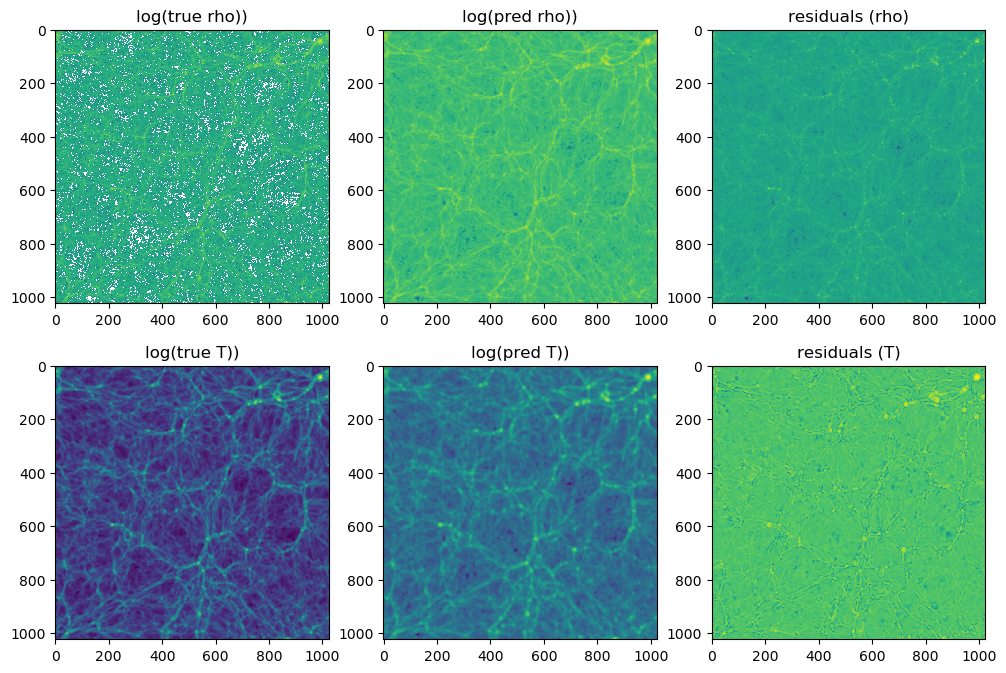

In [158]:
fig, axes = plt.subplots(2, 3, figsize=(12,8))

axes[0,0].imshow(np.log(rho_train))
axes[0,0].set_title('log(true rho))')

rho_pred = bary_model(best_rho0, best_sigma_rho, 1.6)
axes[0,1].imshow(np.log(rho_pred))
axes[0,1].set_title('log(pred rho))')

axes[0,2].imshow(np.log(np.abs(rho_train - rho_pred)))
axes[0,2].set_title('residuals (rho)')

axes[1,0].imshow(np.log(temp_train))
axes[1,0].set_title('log(true T))')

temp_pred = bary_model(best_t0, best_sigma_t, 1.6)
axes[1,1].imshow(np.log(temp_pred))
axes[1,1].set_title('log(pred T))')

axes[1,2].imshow(np.log(np.abs(temp_train - temp_pred)))
axes[1,2].set_title('residuals (T)')

plt.show()

In [170]:
print('Mean loss in rho:', np.mean(np.abs(rho_train - rho_pred)))
print('Mean loss in T:', np.mean(np.abs(temp_train - temp_pred)))

Mean loss in rho: 1.6190977
Mean loss in T: 2168.488


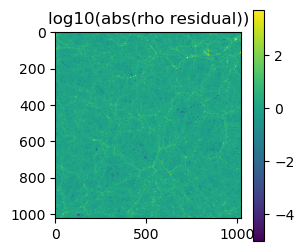

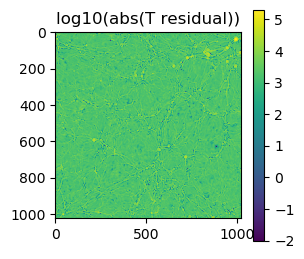

In [167]:
plt.figure(figsize=(3,3))
plt.imshow(np.log10(np.abs(rho_train - rho_pred)))
plt.title('log10(abs(rho residual))')
plt.colorbar()
plt.show()

plt.figure(figsize=(3,3))
plt.imshow(np.log10(np.abs(temp_train - temp_pred)))
plt.title('log10(abs(T residual))')
plt.colorbar()
plt.show()

# Perform optimization

When we feed the input $\rho$ into the model, it returns the output $\tau_{real}$.

In [24]:
import eos
import grid
import snapshot

from spectrum import gmlt_spec_od_grid

In [19]:
size

[0.020599365234375, 0.020599365234375, 21.09375]

In [31]:
## take a skewer
shape = [1, 1, 1024]
size = [21.09375 / 1024 * x for x in shape]
inds = (0, 0, slice(0, shape[2]))
rho_true = DM_dens[inds]
treal_true = treal[inds]
# expand dimensions
rho_true = rho_true[None, None, :]
treal_true = treal_true[None, None, :]

## load in snapshot properties
filename = "../../../../../cscratch1/sd/jupiter/sim2_z3_FGPA_cgs.h5"
snap = snapshot.Snapshot(filename)

a = snap.scale_factor
z = snap.z
u = snap.universe
h = u.h
omega_b = u.omega_b

## define eos object
rho_crit_100_cgs = 1.8788200386793017e-29
mean_rhob_cgs = omega_b * h*h * rho_crit_100_cgs
a3_inv = 1.0 / (a * a * a)
rhob_cgs_conversion = mean_rhob_cgs * a3_inv

eos_obj = eos.EOS_at_z(z, rhob_cgs_conversion)

In [43]:
## create starting point for optimization (random noise)
tf.random.set_seed(5)
log10_noise = tf.random.normal(shape, 0, 0.5, tf.float64, seed=1)
rho_pred = tf.Variable(10**log10_noise)

## define the model
rho_0 = 3.2
sigma_rho = 1.4
T_0 = 9800
sigma_T = 3.3
gamma = 1.6

def model(rho_pred):
    # get rho and T skewers from analytical formulas
    rhob = rho_0*(scipy.ndimage.gaussian_filter(rho_pred, sigma_rho))**(gamma - 1)
    temp = T_0*(scipy.ndimage.gaussian_filter(rho_pred, sigma_T))**(gamma - 1)
    
    # get the n_hi grid via eos object
    log10_rhob = np.log(rhob) / np.log(10)
    log10_temp = np.log(temp) / np.log(10)
    nhi_field = eos_obj.compute_nhi(log10_rhob, log10_temp)
    nhi = grid.Grid(nhi_field, shape, size)
    
    # get real-space optical depth
    vpara = np.zeros(shape)
    treal_pred = gmlt_spec_od_grid(snap.universe, snap.z, nhi.size,
                nhi_field, temp, vpara, shape[2])
    
    return treal_pred.field

# loss function
mse = keras.losses.MeanSquaredError()
loss_fn = lambda: mse(model(rho_pred), treal_true)

# optimizer
optim = tf.optimizers.Adam(learning_rate=0.1)
#optim = keras.optimizers.SGD(learning_rate=1e3)

In [41]:
treal = model(rho_pred)
print(treal.field.shape)

tau duration: 0.9588496685028076
(1, 1, 1024)


In [46]:
tf.executing_eagerly()

True

In [47]:
print('Initial loss:', mse(model(rho_pred), treal_true).numpy())

losses = tfp.math.minimize(loss_fn,
                           num_steps=10,
                           optimizer=optim)

print('Final loss:', losses[-1].numpy())
treal_pred_final = model(rho_pred) # final prediction for tau_real

tau duration: 0.802208662033081
Initial loss: 377.73724


NotImplementedError: numpy() is only available when eager execution is enabled.

In [ ]:
# TODO: replicate results with Gimlet's tau_real
# ...

# Plot reconstruction results

In [ ]:
# true and predicted log(input)
plt.figure(figsize=(10,4))

plt.plot(np.log10(rho_true), color='black', label='log10(rho) (true)')
plt.plot(np.log10(rho_pred), 'blue', label = 'log10(rho) (pred)', alpha=0.5)
plt.title('log10(rho)')
plt.ylim(-5, 3)
plt.legend()
plt.show()

# true and predicted "data"
plt.figure(figsize=(10,4))
plt.plot(treal_true, color='black', label='tau_real (true)')
plt.plot(treal_pred_final, 'blue', label = 'tau_real (pred)', alpha=0.5)
plt.title('tau_real')
plt.legend()
plt.show()

# loss
plt.figure(figsize=(10,4))
plt.plot(np.log10(losses))
plt.title('log10(loss)')
plt.show()